# Inference results

In [65]:
import json
import pandas as pd
import glob
import os
import numpy as np
from plotnine import *

### Plot of the sweeps of the full system including Socratic prompting and the penalty

In [66]:
result_files = glob.glob(
    "../../inference_result/facebook/opt-1.3b/AudioCaps/excludes_prompt_magic/output_jsons/validation/*.json"
)
result_files_html = glob.glob(
    "../../inference_result/facebook/opt-1.3b/AudioCaps/excludes_prompt_magic/output_tables/validation/*.html"
)

hyperparam_dicts = []
for file in result_files:
    if "2023-06" in file:
        try:
            f = open(file)
            hyperparam_dict = json.load(f)[0]
            hyperparam_dict["res_file_name"] = file
            hyperparam_dicts.append(hyperparam_dict)

        except:
            print("Corrupted files: {}".format(file))
            continue

In [67]:
len(result_files)

1342

In [68]:
len(result_files_html)

965

All ext files contain the ChatGPT list. Since our best model was found to be with the AudioSetKW list only, we only employ this list in the hyperparameter tuning.

In [69]:
res_df = pd.DataFrame.from_records(hyperparam_dicts).drop(
    columns=[
        "prediction",
        "captions",
        "sound_name",
        "included_prompt_in_magic",
        "n_test_samples",
        "CLAP_type",
        "split",
        "dataset",
        "clip_text_max_len",
        "k",
        "keyword_prompt",
        "decoding_len",
    ]
)


res_df["Mean NLG Score"] = (
    res_df["res_file_name"]
    .apply(lambda x: os.path.split(x)[-1])
    .apply(lambda x: x.split("_")[0])
)

res_df["Mean NLG Score"] = pd.to_numeric(res_df["Mean NLG Score"])

res_df["timestamp"] = res_df["res_file_name"].apply(
    lambda x: str.split(os.path.split(x)[-1], "_")[1]
)

all_timestamps = res_df["timestamp"]

res_df.drop(columns=["res_file_name"], inplace=True)

res_df.rename(columns={"l": "number_of_keywords"}, inplace=True)

res_df["number_of_keywords"] = res_df["number_of_keywords"].apply(lambda x: str(x))
res_df["temperature"] = res_df["temperature"].apply(lambda x: round(x, 1))
res_df["temperature"] = res_df["temperature"].apply(lambda x: str(x))
res_df["end_penalty"] = res_df["end_penalty"].apply(lambda x: round(x, 2))
# res_df["alpha"] = res_df["alpha"].apply(lambda x: str(x))

In [70]:
res_df_plot = res_df[
    (res_df["alpha"] == 0)
    & (res_df["prompt"] != "This is the sound of ")
    & (res_df["number_of_keywords"] == "2")
]

res_df_plot["number_of_keywords"] = np.where(
    res_df_plot["number_of_keywords"] == "2", "$l = 2$ keywords", "other"
)
res_df_plot["alpha"] = np.where(res_df_plot["alpha"] == 0.0, "$\\alpha = 0$", "other")
res_df_plot.rename(
    columns={"end_penalty": "$\\gamma$", "temperature": "$\\tau$"}, inplace=True
)

y_grid = np.linspace(np.min(res_df_plot["Mean NLG Score"]), 0.185, 11)
highest_val = np.expand_dims(np.array(np.max(res_df_plot["Mean NLG Score"])), axis=0)
y_grid = np.concatenate((y_grid, highest_val))

/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

We only present the best validation runs to ensure readability

/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 12 x 6 in image.
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../plots/AudioCaps_validation_sweep.png
/home/sfauth/miniconda3/envs/MAGIC/lib/python3.7/site-packages/plotnine/geoms/geom_point.py:70: UserWarning: You passed a edgecolor/edgecolors (['#80007fff', '#ff0000ff', '#0000ffff', '#80007fff', '#80007fff', '#0000ffff', '#80007fff', '#ff0000ff', '#ff0000ff', '#ff0000ff', '#0000ffff', '#ff0000ff', '#0000ffff', '#0000ffff', '#80007fff', '#0000ffff', '#0000ffff', '#ff0000ff', '#ff0000ff', '#80007fff', '#0000ffff', '#0000ffff', '#0000ffff', '#0000ffff', '#80007fff', '#80007fff', '#0000ffff', '#ff0000ff', '#ff0000ff', '#0000ffff', '#80007fff', '#ff0000ff', '#0000ffff', '#80007fff', '#80007fff', '#ff0000ff', '#80007fff', '#ff0000ff', '#80007fff', '#ff0000ff', '#0000ffff', '#80007fff', '#0000ffff', '#80007fff', '

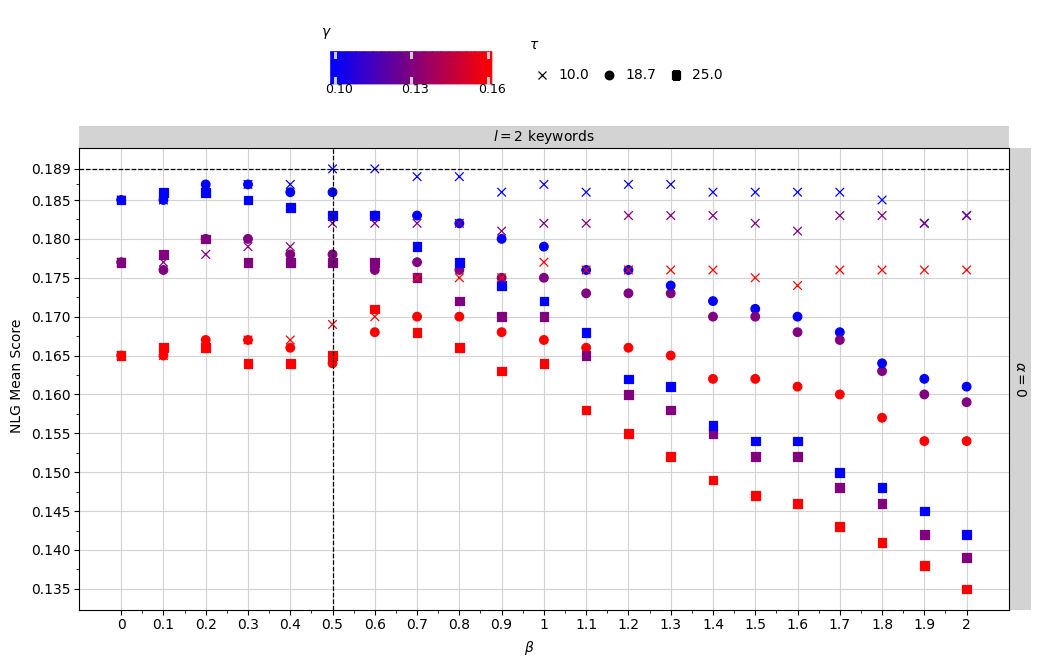

<ggplot: (8726266462952)>

In [74]:
plot = (
    ggplot(res_df_plot)
    + aes(x="beta", y="Mean NLG Score", color="$\\gamma$", shape="$\\tau$")
    + facet_grid("alpha ~ number_of_keywords")
    + scale_color_gradient(
        low="blue", high="red", limits=(0.1, 0.16), breaks=(0.1, 0.13, 0.16)
    )
    + geom_point(size=3)
    + geom_hline(
        yintercept=np.max(res_df_plot["Mean NLG Score"]),
        color="black",
        linetype="dashed",
    )
    + geom_vline(
        xintercept=res_df_plot[
            res_df_plot["Mean NLG Score"] == np.max(res_df_plot["Mean NLG Score"])
        ].iloc[-1:]["beta"],
        color="black",
        linetype="dashed",
    )
    + scale_x_continuous(breaks=np.linspace(0, 2, 21))
    + scale_y_continuous(breaks=y_grid)
    + xlab("$\\beta$")
    + ylab("NLG Mean Score")
    + scale_shape_manual(values=["x", "o", "s"])
    + theme_classic()
)

plot = plot + theme(
    guides(color=guide_colorbar(barheight=2)),
    figure_size=(12, 6),
    # plot_title=element_text(text="Hyperparameter Sweep Results on the AudioSet Validation set", size=18),
    panel_grid_minor=element_blank(),
    panel_grid_major=element_line(color="lightgray"),
    strip_background=element_rect(fill="lightgray"),
    legend_position="top",
    legend_box="horizontal",
    # legend_key_height=15, legend_key_width=35
    # legend_text=element_text(margin={"r": 50}
)

plot.save("../plots/AudioCaps_validation_sweep.png", dpi=320)

plot